In [30]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.signal.windows import tukey

### Question 1
### (a)
From the lecture notes, we know that the spectral densities for $MA(q)$, $AR(p)$ and $ARMA(p,q)$ processes are 
\begin{align*}
S_{MA}(f) &= \sigma_{\varepsilon}^2 |1 - \theta_{1,q}e^{-i2\pi f} - \cdots - \theta_{q,q}e^{-i2\pi fq}|^2\\
S_{AR}(f) &= \frac{\sigma_{\varepsilon}^2}{|1 - \phi_{1,p}e^{-i2\pi f} - \cdots - \phi_{p,p}e^{-i2\pi fp}|^2}\\
S_{ARMA}(f) &= \sigma_{\varepsilon}^2\frac{|1 - \theta_{1,q}e^{-i2\pi f} - \cdots - \theta_{q,q}e^{-i2\pi fq}|^2}{|1 - \phi_{1,p}e^{-i2\pi f} - \cdots - \phi_{p,p}e^{-i2\pi fp}|^2}.
\end{align*}
Note that the third formula can be used for all cases in our function. So if we have an $MA(q)$ process, then in our function the phis list will be empty and the denominator will be $|1|^2 = 1$ resulting in the formula for the $S_{MA}(f)$.
Below, for each element in f we first calculate the transfer functions $G_{\phi}(f[i])$ and $G_{\theta}(f[i])$ and then we determine the sdf evaluated at $f[i]$ (we require $f[i]$ to be in $[-1/2, 1/2]$ for the sdf to be non-zero).

In [58]:
def S_ARMA(f, phis, thetas, sigma2):
    """Input: 
    f: list of frequences at which it should be evaluated
    phis: the list [phi_{1,p},..., phi_{p,p}]
    thetas: the list [theta_{1,q},..., theta_{q,q}]
    sigma2: a scalar for the variance of the white noise
    Output:
    S: theoretical spectral density function for a ARMA(p,q) process evaluated at f."""

    # find p and q
    p = len(phis)
    q = len(thetas)

    # initialize sdf to be zero everywhere
    S = [0 for i in range(len(f))]
    
    # for each element in f, evaluate the sdf
    for i in range(len(f)):

        # sdf is non-zero only if f is between -1/2 and 1/2
        if -0.5 <= f[i] <= 0.5:
            
            # initialize the two sums
            G_theta = 1
            G_phi = 1

            # G_phi = (1 - phi_1*exp(-i*2*pi*f*1) - ... - phi_p*exp(-i*2*pi*f*p))
            for m in range(p):
                G_phi = G_phi - phis[m]*np.e**(-1j*2*np.pi*f[i]*(m+1))
            
            # G_theta = (1 - theta_1*exp(-i*2*pi*f*1) - ... - theta_q*exp(-i*2*pi*f*q))
            for n in range(q):
                G_theta = G_theta - thetas[n]*np.e**(-1j*2*np.pi*f[i]*(n+1))

            # update the ith element of S
            S[i] = sigma2*(abs(G_theta))**2/(abs(G_phi))**2
 
    return S

### (b)
We now simulate a Gaussian $ARMA(2,2)$ process of length $N$ given by
\begin{equation*}
X_t = \phi_{1,2}X_{t-1} + \phi_{2,2}X_{t-2} + \epsilon_t - \theta_{1,2}\epsilon_{t-1} - \theta_{2,2}\epsilon_{t-2} \quad t>2.
\end{equation*}

In [108]:
def ARMA22_sim(phis, thetas, sigma2, N):
    """Input:
    phis: the list [phi_{1,2}, phi_{2,2}]
    thetas: the list [theta_{1,2}, theta_{2,2}]
    sigma2: a scalar for the variance of the white noise
    N: length of simulated process
    Output: 
    Time series of length N simulated by the ARMA(2,2) process."""
    
    # initialize list recording the values of the stochastic process
    X = [0,0]

    # create list with N + 100 epsilons following normal distribution with mean 0 and variance sigma2
    epsilons = [np.random.normal(0,np.sqrt(sigma2)) for i in range(N+100)]

    # recursively append the values Xt
    for i in range(2,N+100):
        X.append(phis[0]*X[i-1] + phis[1]*X[i-2] + epsilons[i] - thetas[0]*epsilons[i-1] - thetas[1]*epsilons[i-2])
    
    # return only the N values after the first 100
    return X[100:]

### (c)
The Fast Fourier Transform algorithm $fft(X)$ takes our $N$ dimensional time series and outputs an $N$ dimensional list $y$, where
\begin{equation*}
y[k] = \sum_{n = 0}^{N-1} X[k] e^{-2\pi i f_k n}, \quad f_k = k/N, \quad k = 0, 1,..., N-1.
\end{equation*}
This is similar to the fourier transform we need for computing the periodogram, which is given by
\begin{equation*}
\sum_{t = 1}^{N} X_t e^{-i2\pi f t}.
\end{equation*}
Noting that python counts from 0 instead of 1, we can transform this into 
\begin{equation*}
a[k] = \sum_{k = 0}^{N-1} X[k] e^{-i2\pi f_k (k+1)} = y[k]e^{-i 2\pi f_k}.
\end{equation*}
After obtaining $a[k]$, we have the following estimate of the sdf:
\begin{equation*}
S[k] = \frac{1}{N} \big| a[k] \big|^2.
\end{equation*}
This is calculated for the Fourier frequencies $f_k$, which range from $0$ to $(N-1)/N$, however, in the lecture notes we define the periodogram over $[-1/2, 1/2]$. Using the fact that the sdf is periodic, we can obtain $\hat{S}^p(f_k)$ by moving the first half of the resulting $N$ dimensional vector after the second half, i.e. rearranging the frequencies so that the N Fourier frequencies lie in the interval $[-1/2, 1/2]$. We do this so that the resulting periodogram is compatible with our definition in the notes. 

In [149]:
def periodogram(X):
    """Input:
    X: numpy array of the time series
    Output:
    The periodogram at the Fourier frequencies for X."""
    
    N = len(X)
    y = list(fft(X))  # produces an array of length N of the Fourier transform of X at f = k/N
    
    # obtain the needed array a[k] as descibed above
    for i in range(N):
        y[i] = abs(y[i]*np.e**(-1j*2*np.pi*i/N))**2/N
    
    # transform the array into a list
    #S = list(a)

    # compute the squared absolute value and divide by N
    #for i in range(N):
    #    S[i] = abs(S[i])**2/N
    
    # return the periodogram by swapping the first and second halves of S
    return y[int(N/2):] + y[0:int(N/2)]

We now compute the direct spectrail estimate at the Fourier frequencies using a $p \times 100 \%$ cosine taper. From the lecture notes, we use $h[i]=$
\begin{align*}
&\frac{C}{2}(1 - \cos(\frac{2\pi(i+1)}{[pN]+1})), \quad &0 \le i \le \frac{[pN]}{2}\\
&C, \quad &\frac{[p(N-1)]}{2} < i < N - \frac{[2(N-1)]}{2}\\
&\frac{C}{2}(1 - \cos(\frac{2\pi(N - i)}{[pN]+1})), \quad &N - \frac{[2(N-1)]}{2} \le i \le N-1,\\
\end{align*}
where we have adapted the $h[i]$ since python counts from 0. In the code, we first calculate this with $C = 1$ and then we compute the sum of $h[i]^2$ and update the h's so that the sum is equal to $1$.

Now we want to calculate 
\begin{equation*}
\sum_{t = 1}^N h_tX_te^{i2\pi f t} \quad \text{or since python counts from 0} \quad \sum_{n = 0}^{N-1} h[k]X[k]e^{i2\pi f_k (n+1)}
\end{equation*}
Once again, since the $fft$ algorithm computes
\begin{equation*}
y[k] = \sum_{n = 0}^{N-1} h[k]X[k] e^{-2\pi i f_k n}, \quad f_k = k/N, \quad k = 0, 1,..., N-1.
\end{equation*}
So we transform this into 
\begin{equation*}
J(f_k) = y[k] e^{-i2 \pi f_k}
\end{equation*}
Now we can compute the direct spectral estimator
\begin{equation*}
S[k] = \big| J(f_k) \big|^2
\end{equation*}
Once again, we swap the first and second halves of the resulting direct spectral estimator, so that the domain is $[-1/2, 1/2]$ instead of $[0,1]$. We can do this because of the periodic property of the sdf. 

In [164]:
def direct(X,p):
    """
    Input:
    X: time series
    p: variable for cosine taper
    Output:
    Direct spectral estimate at the Fourier frequencies using px100% cosine taper for X."""
    
    N = len(X)

    # compute the h[i] for C = 1
    h = np.ones(N)
    
    for i in range(0, int(np.floor(p*(N))/2)):
        h[i] = h[i]*0.5*(1 - np.cos(2*np.pi*(i+1)/(np.floor(p*N)+1)))
    
    for i in range(N - int(np.floor(p*(N))/2), N):
        h[i] = h[i]*0.5*(1 - np.cos(2*np.pi*(N-i)/(np.floor(p*N)+1)))


    # calculate the sum of the h[i] when C = 1
    sum_h = 0
    for i in range(N):
        sum_h += h[i]**2

    # find the value of C such that the squared sum is 1 and update the h
    C = 1/np.sqrt(sum_h)
    h = h*C
    
    # use fft lgorithm for h[i]*X[i]
    J = list(fft([X[i]*h[i] for i in range(N)]))
    
    # obtain the needed array J[k] as descibed above
    for i in range(N):
        J[i] = abs(J[i]*np.e**(-1j*2*np.pi*i/N))**2

    
    # return the direct spectral estimator by swapping the first and second halves of S
    return J[int(N/2):] + J[0:int(N/2)]

### (d)


In [146]:
f_prime = 12/128
r = 0.8
phi = [2*r*np.cos(2*np.pi*f_prime), -r**2]
for i in range(10000):
    X = ARMA22_sim(phi, [-0.5,-0.2], sigma2=1, N=128)
    S_periodogram = periodogram(X)
    S_direct = direct(X,0.25)

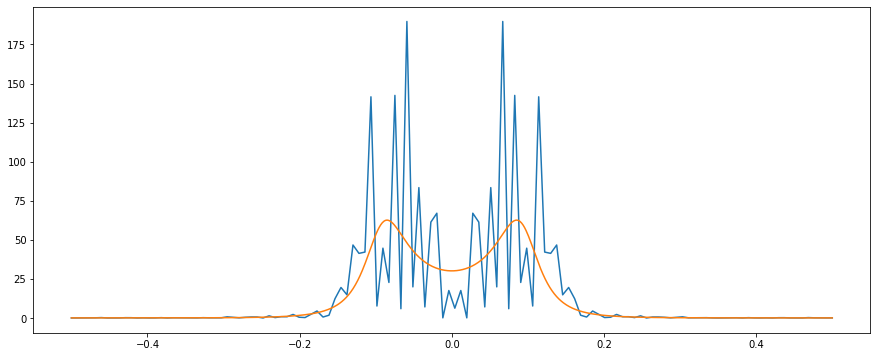

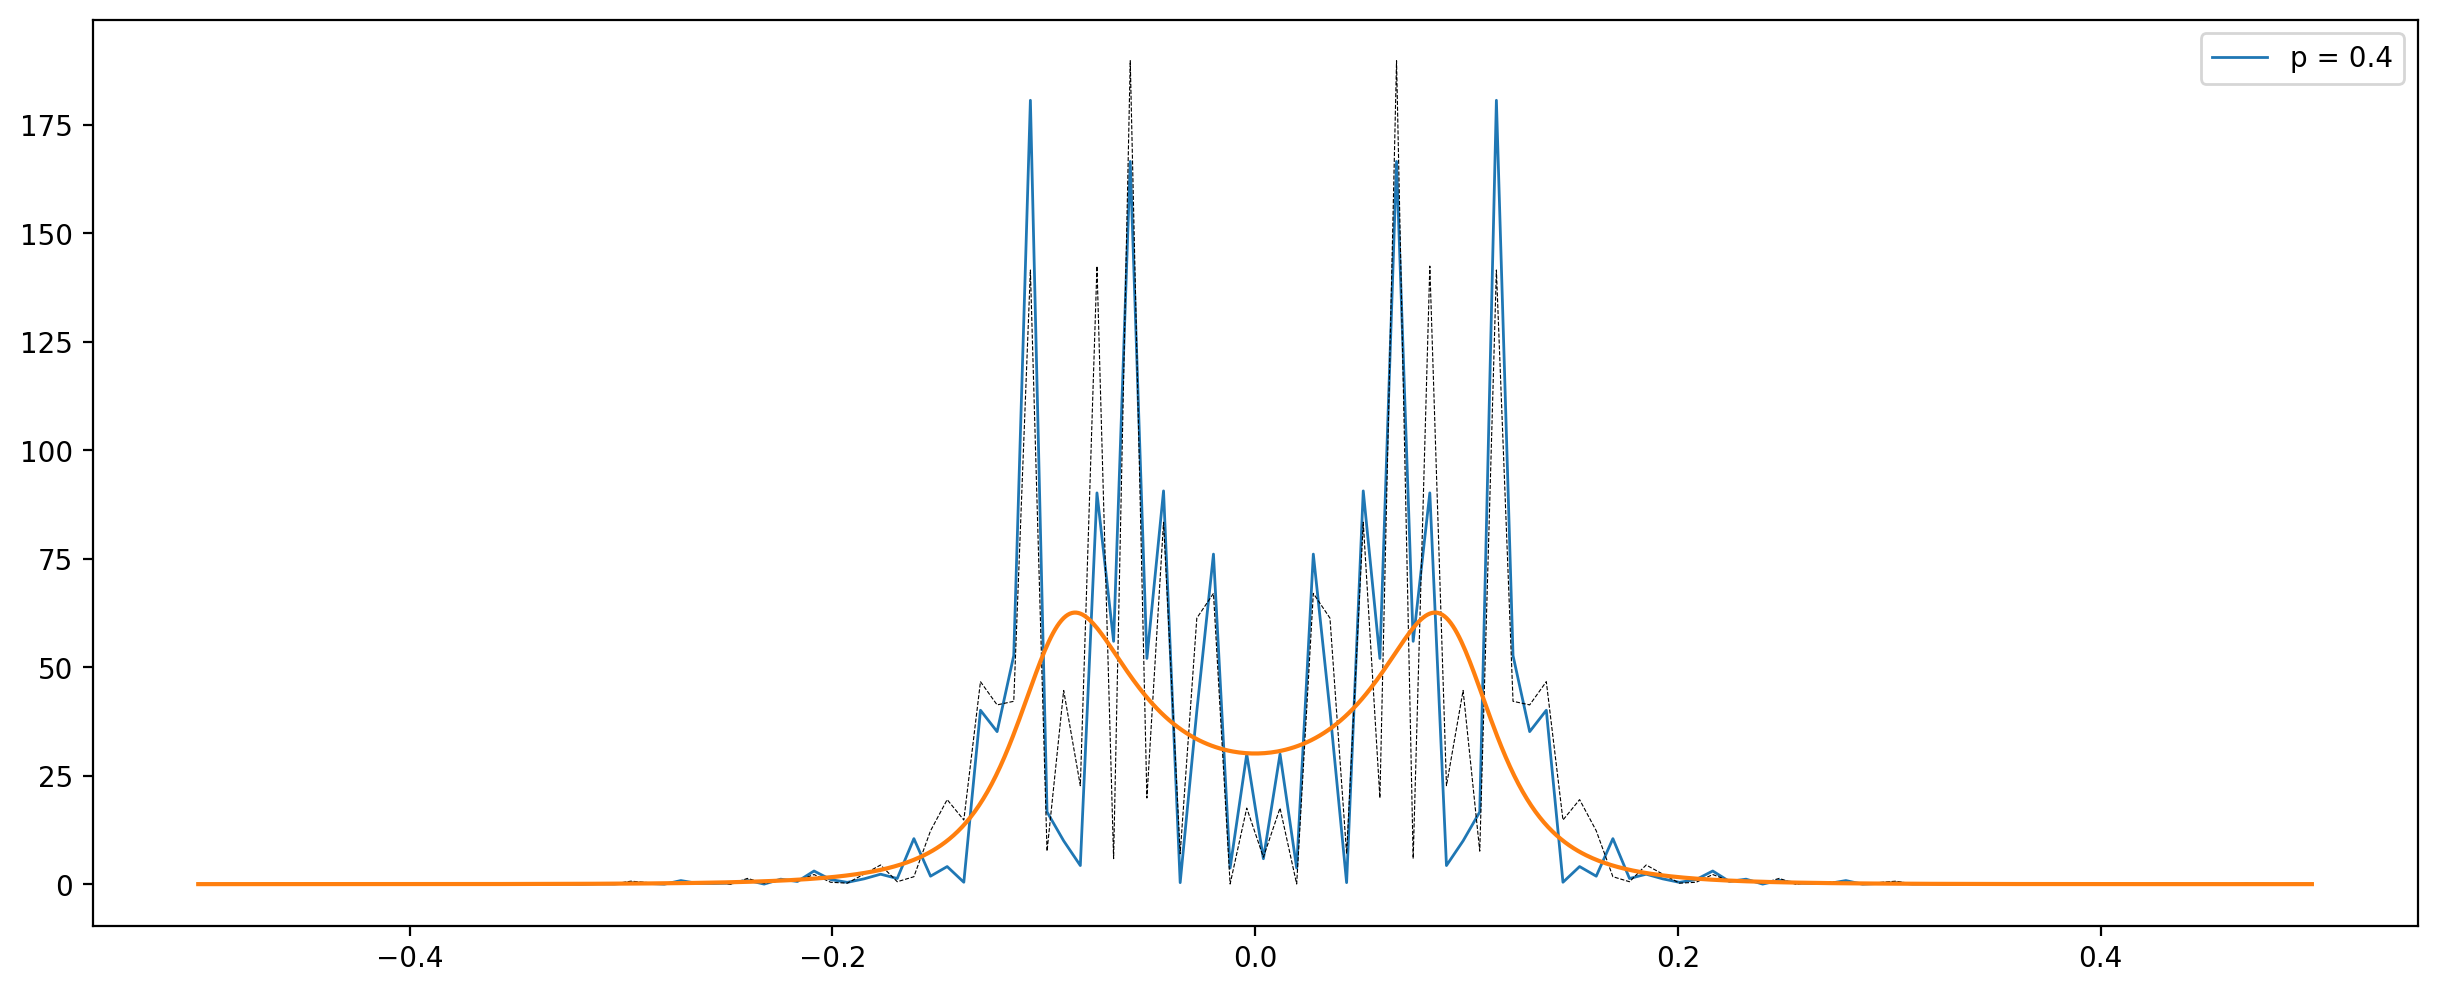

In [165]:
N = 128
F = 12/N
X = ARMA22_sim([2*r*np.cos(2*np.pi*F), -r**2],[-0.5,-0.2], sigma2=1, N=N)



T = np.linspace(-1/2,1/2,1000)
s = S_ARMA(T,phis=[2*r*np.cos(2*np.pi*F), -r**2],thetas=[-0.5,-0.2], sigma2=1)


plt.figure(figsize=(15, 6))
t = np.linspace(-0.5,0.5,len(X))
q = periodogram(X)
plt.plot(t,q)
plt.plot(T,s)
plt.show()

P = [0.05, 0.1, 0.25, 0.5]
P2 = [0.4]
plt.figure(figsize=(15, 6), dpi = 200)
for p in P2:
    plt.plot(t,direct(X,p), linewidth = 1,label = f"p = {p}")
plt.plot(t,q, "k--", linewidth = 0.4)
plt.plot(T,s)
plt.legend()
plt.show()
